### WPM ratios

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from hol.wpm_ratios import WPMRatios

year1 = 1750
year2 = 1920

years = range(year1, year2)

ratios = WPMRatios(year1, year2)

### Linear regressions

jesus
0.00411344841409 1.27337444858e-15


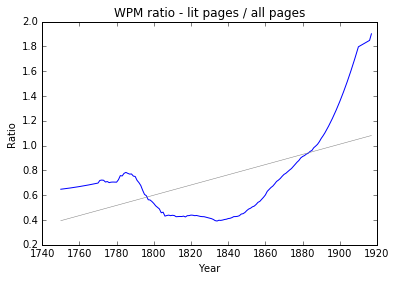

court
-0.002224727428 2.13921287138e-61


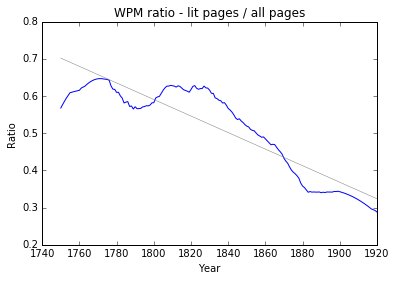

crown
0.00983647539388 6.5521977002e-44


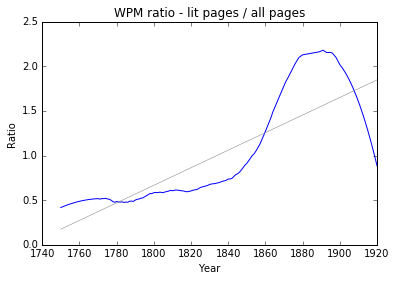

cloth
0.0238399727658 1.65909836113e-37


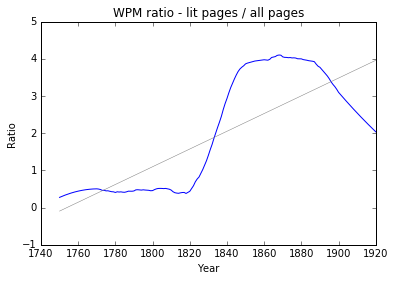

In [5]:
import numpy as np
import statsmodels.api as sm

from hol.utils import lin_reg

def plot_linreg(token):

    series = ratios.smooth_series(token)

    fit = lin_reg(series)

    x1 = list(series.keys())[0]
    x2 = list(series.keys())[-1]

    y1 = fit.predict()[0]
    y2 = fit.predict()[-1]
    
    print(token)
    print(fit.params[1], fit.pvalues[1])

    plt.title('WPM ratio - lit pages / all pages')
    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.plot(*zip(*series.items()))
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    plt.show()

plot_linreg('jesus')
plot_linreg('court')
plot_linreg('crown')
plot_linreg('cloth')

### Token -> slope, p<0.01

In [6]:
import math

def print_ratios(tokens, cols=5):
    
    # Get row count and figure size.
    rows = math.ceil(len(tokens) / cols)
    figsize = (cols*2, rows*2)
    
    # Make the figure + axes.
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    fig.tight_layout(pad=0, h_pad=2, w_pad=0.1)
    
    for i, token in enumerate(tokens):
        
        ax = axarr[math.floor(i/cols)][i%cols]
        ax.set_title(token)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
        ax.tick_params(labelsize=8)
        ax.set_xlim(year1, year2)
        
        s = ratios.clean_series(token)
        
        ax.plot(
            *zip(*s.items()),
            linestyle='none',
            marker='.',
            markersize=2,
        )

### Decreasing

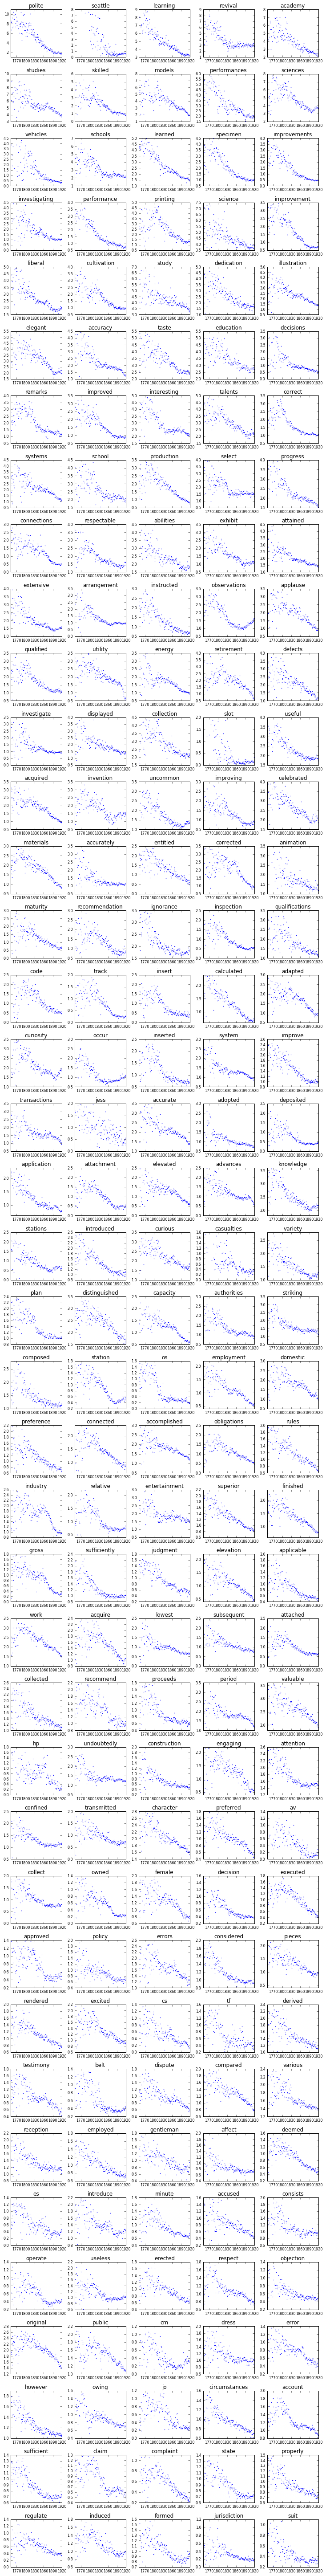

In [7]:
def score(series):
    
    fit = lin_reg(series)
    
    if fit.pvalues[1] < 1e-20:
        return -fit.params[1]
    
result = ratios.query_series(score)

print_ratios(list(result.keys())[:200])

### Increasing

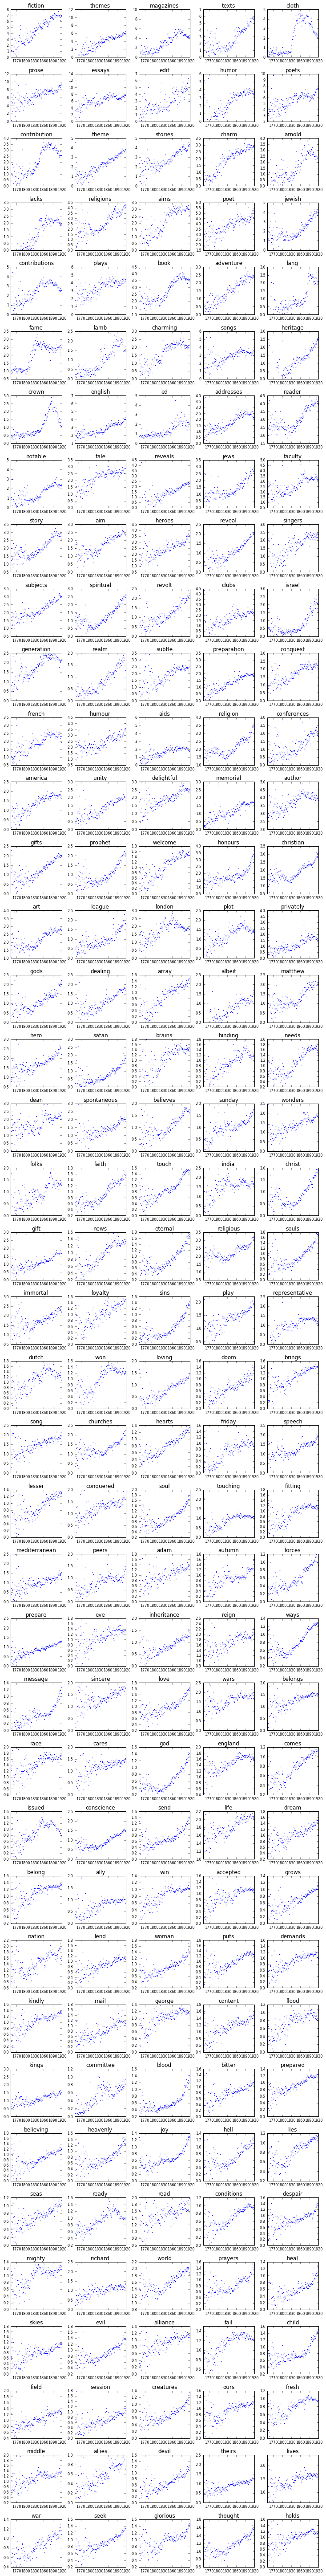

In [8]:
def score(series):
    
    fit = lin_reg(series)
    
    if fit.pvalues[1] < 1e-20:
        return fit.params[1]

result = ratios.query_series(score)

print_ratios(list(result.keys())[:200])

### High median correlation

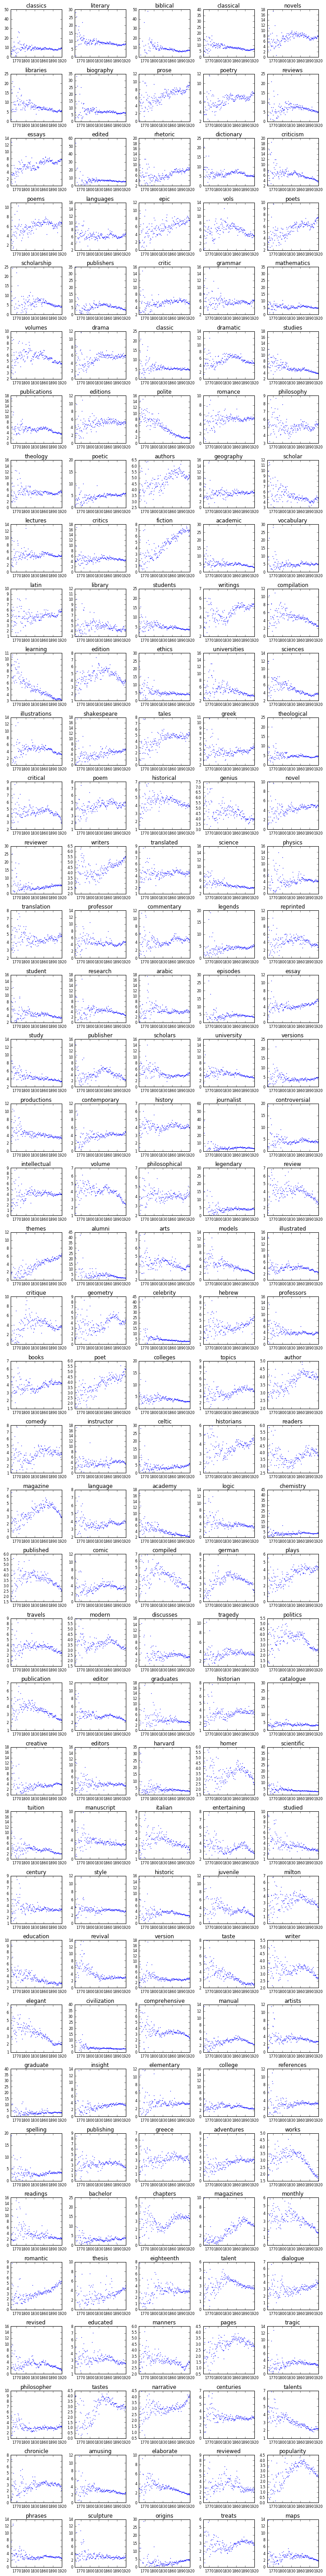

In [9]:
def _high_median(series):

    vals = list(series.values())

    if len(vals) < 150:
        return None

    return np.median(vals)

high_median = ratios.query_series(_high_median)

print_ratios(list(high_median.keys())[:200])

### Excellence

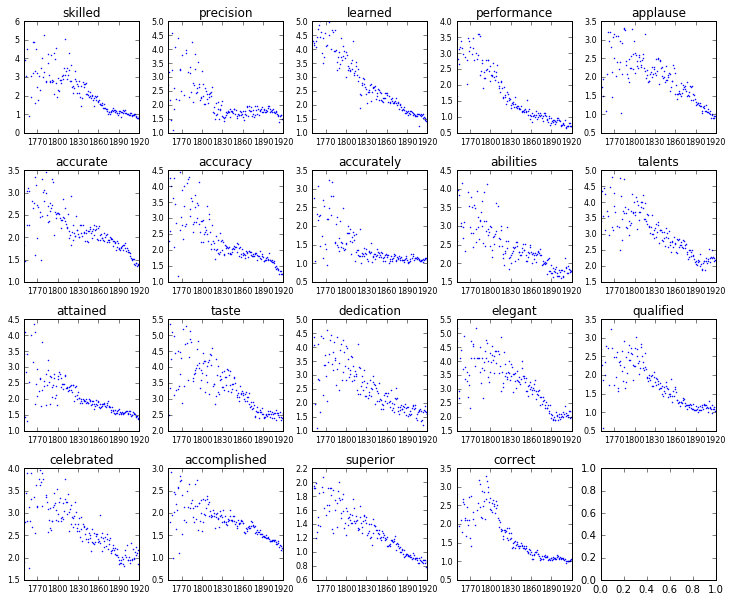

In [31]:
print_ratios([
    'skilled',
    'precision',
    'learned',
    'performance',
    'applause',
    'accurate',
    'accuracy',
    'accurately',
    'abilities',
    'talents',
    'attained',
    'taste',
    'dedication',
    'elegant',
    'qualified',
    'celebrated',
    'accomplished',
    'superior',
    'correct',
])

### Usefulness

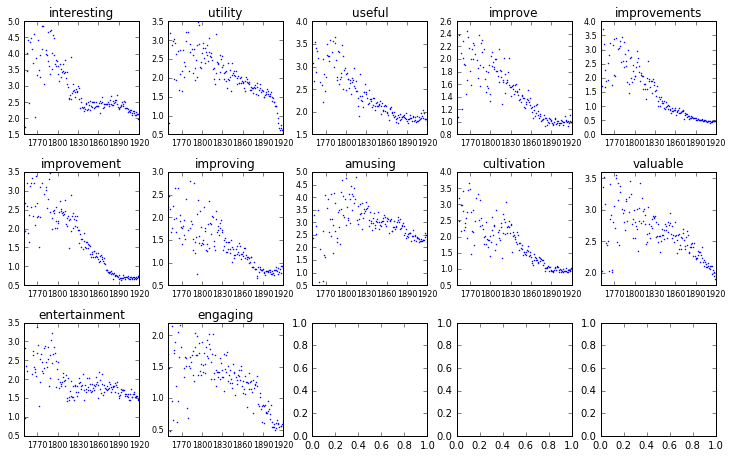

In [18]:
print_ratios([
    'interesting',
    'utility',
    'useful',
    'improve',
    'improvements',
    'improvement',
    'improving',
    'amusing',
    'cultivation',
    'valuable',
    'entertainment',
    'engaging',
])

### Education

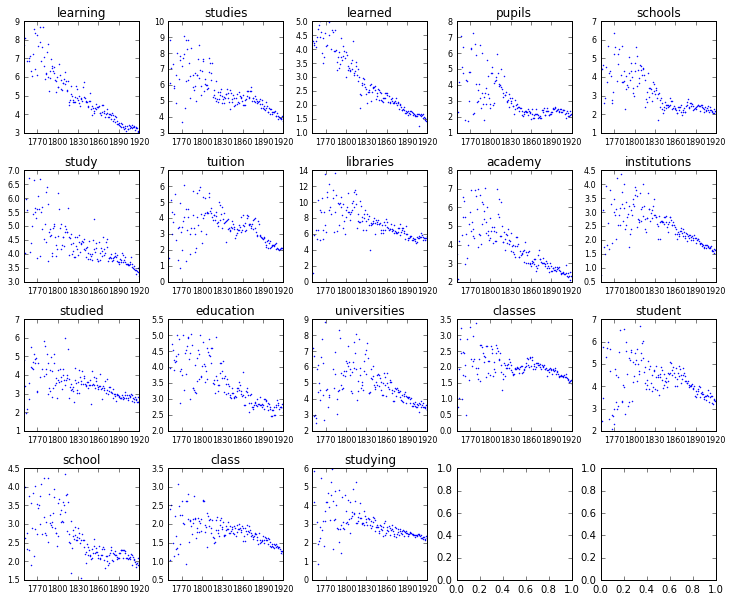

In [19]:
print_ratios([
    'learning',
    'studies',
    'learned',
    'pupils',
    'schools',
    'study',
    'tuition',
    'libraries',
    'academy',
    'institutions',
    'studied',
    'education',
    'universities',
    'classes',
    'student',
    'school',
    'class',
    'studying',
])

### Science

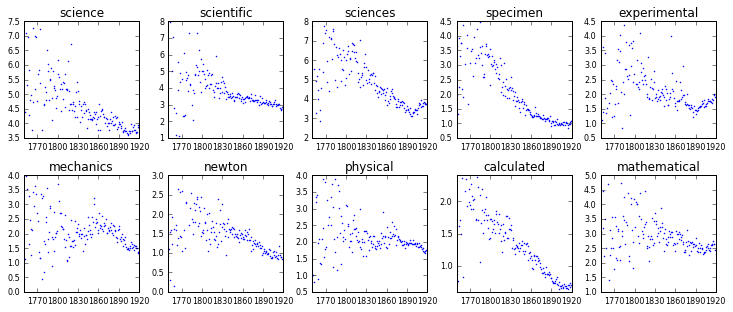

In [33]:
print_ratios([
    'science',
    'scientific',
    'sciences',
    'specimen',
    'experimental',
    'mechanics',
    'newton',
    'physical',
    'calculated',
    'mathematical',
])

### Weighted KDEs

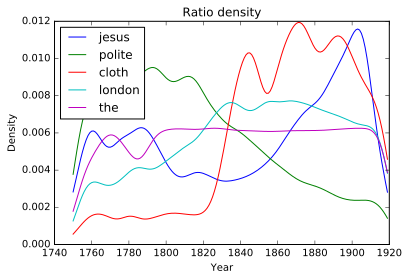

In [174]:
def plot_pdfs(tokens, legend=False):
    for t in tokens:
        
        samples = ratios.pdf(t, years)
        
        plt.title('Ratio density')
        plt.xlabel('Year')
        plt.ylabel('Density')
        plt.plot(*zip(*samples.items()), label=t)
        
        if legend:
            plt.legend(loc='upper left')
        
    plt.show()

plot_pdfs([
    'jesus',
    'polite',
    'cloth',
    'london',
    'the',
], legend=True)

### PDFs for high-correlation words

In [128]:
from collections import OrderedDict

from hol.utils import sort_dict

tokens = list(high_median.keys())[:500]

pdfs = OrderedDict([
    (token, ratios.pdf(token, years))
    for token in tokens
])

def query_pdfs(_lambda):
    
    result = OrderedDict()
    
    for token, pdf in pdfs.items():
        result[token] = _lambda(pdf)
        
    return sort_dict(result)

1760-1780       1780-1800       1800-1820       1820-1840       1840-1860       1860-1880      1880-1900      1900-1920
--------------  --------------  --------------  --------------  --------------  -------------  -------------  -------------
civilization    investigations  printing        clever          cloth           cloth          texts          texts
learned         specimens       investigations  notices         quarterly       harper         harper         origins
pupils          celebrity       discrimination  quarterly       clever          texts          cloth          harper
specimens       selection       selection       cloth           experiences     hugo           magazines      magazines
princeton       discrimination  specimens       selection       harper          quarterly      humor          humor
revival         polite          skilled         publisher       publisher       jeremy         origins        cloth
academy         civilization    celebrity       print

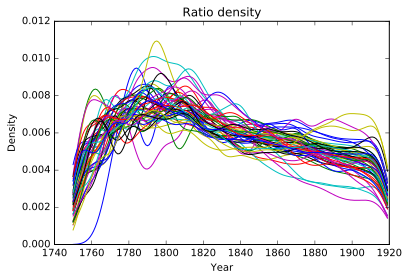

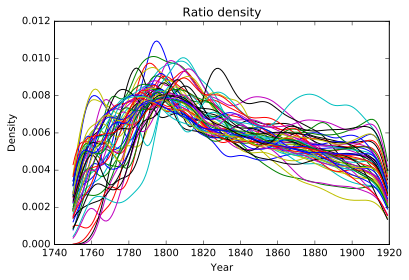

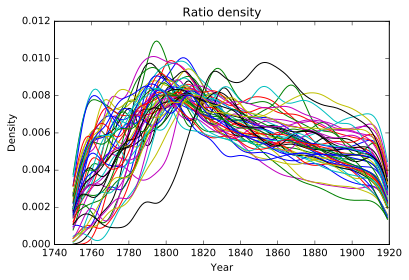

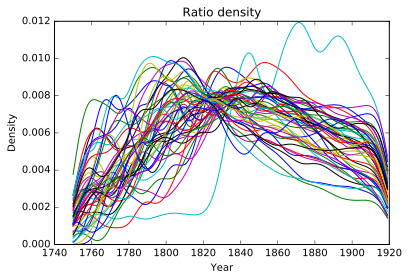

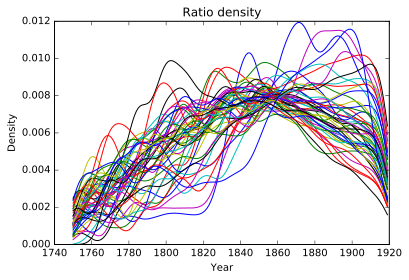

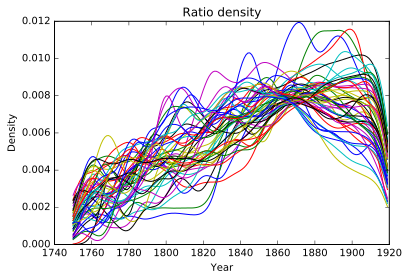

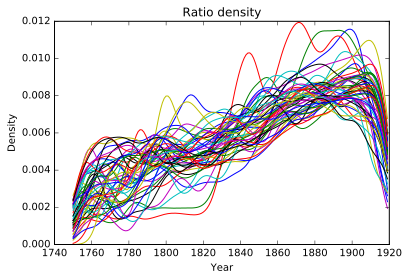

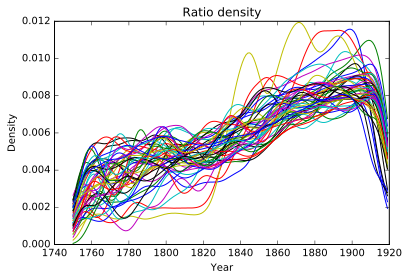

In [175]:
from functools import partial
from tabulate import tabulate

def score(years, pdf):
    return max([pdf.get(y, 0) for y in years])

buckets = [
    (1760, 1780),
    (1780, 1800),
    (1800, 1820),
    (1820, 1840),
    (1840, 1860),
    (1860, 1880),
    (1880, 1900),
    (1900, 1920),
]

cols = [
    query_pdfs(partial(score, range(y1, y2)))
    for y1, y2 in buckets
]

table = []
for i in range(50):
    table.append([list(c.keys())[i] for c in cols])
    
headers = ['{0}-{1}'.format(*b) for b in buckets]
    
print(tabulate(table, headers=headers))

for c in cols:
    plot_pdfs(list(c.keys())[:50])

### PDF clustering

In [130]:
from itertools import combinations
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram

d = []
for pdf1, pdf2 in combinations(list(pdfs.values())[:500], 2):
    
    vals1 = list(pdf1.values())
    vals2 = list(pdf2.values())
    
    d.append(distance.braycurtis(vals1, vals2))

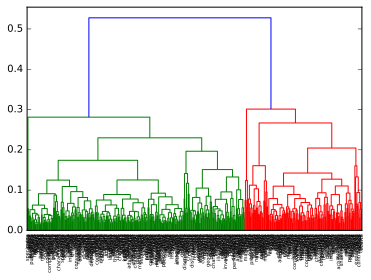

In [188]:
link = linkage(d, method='complete')
dendrogram(link, p=500, truncate_mode='lastp', labels=tokens[:500])

# matplotlib.rcParams['figure.figsize'] = (30.0, 70.0)
# %config InlineBackend.figure_formats = {'svg',}
# plt.savefig('pdfs.svg')

plt.show()

In [195]:
# matplotlib.rcParams['figure.figsize'] = (6, 4)

### Science, medicine, study

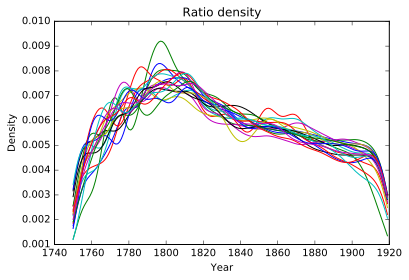

In [181]:
plot_pdfs([
    'scientific',
    'characterized',
    'readings',
    'students',
    'studies',
    'accurate',
    'taste',
    'talents',
    'utility',
    'illustration',
    'systems',
    'school',
    'medical',
    'illustrate',
    'education',
    'studying',
    'sciences',
    'libraries',
    'collection',
])

### Visual art, museums, travel (?)

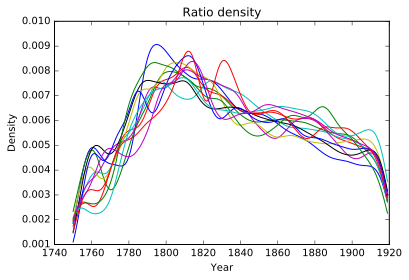

In [182]:
plot_pdfs([
    'museum',
    'sketch',
    'amusing',
    'italian',
    'chinese',
    'geographical',
    'classical',
    'studio',
    'juvenile',
    'drawings',
    'biography',
    'harvard',
])

### Oxbridge

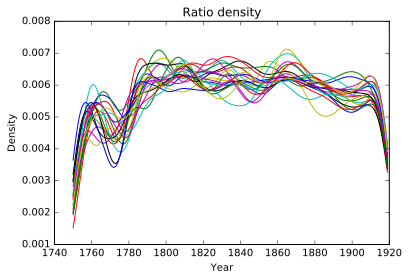

In [183]:
plot_pdfs([
    'centuries',
    'leisure',
    'enthusiasm',
    'sculpture',
    'cambridge',
    'oral',
    'genius',
    'manners',
    'library',
    'arts',
    'anatomy',
    'oxford',
    'gothic',
    'simplicity',
    'writing',
    'editors',
    'languages',
    'grammar',
    'century',
    'morality',
])

### Society, salon, theater

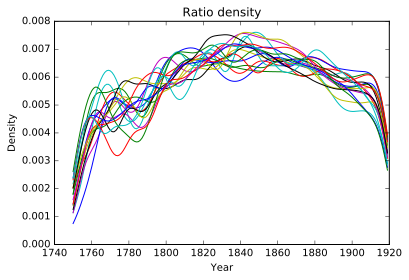

In [184]:
plot_pdfs([
    'authentic',
    'society',
    'series',
    'polish',
    'incidents',
    'theatre',
    'europe',
    'brilliant',
    'intellectual',
    'paintings',
    'vols',
    'dramatic',
    'opera',
    'talent',
    'pen',
    'maps',
    'novels',
    'conversations',
])

### Journalism, serials

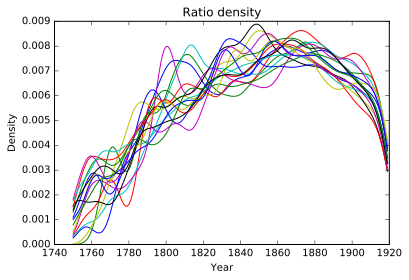

In [179]:
plot_pdfs([
    'discusses',
    'chess',
    'journalist',
    'unique',
    'newest',
    'newspaper',
    'attractive',
    'episode',
    'latest',
    'manual',
    'popular',
    'weekly',
    'composer',
    'magazine',
    'episodes',
    'popularity',
])

### Classics, philosophy

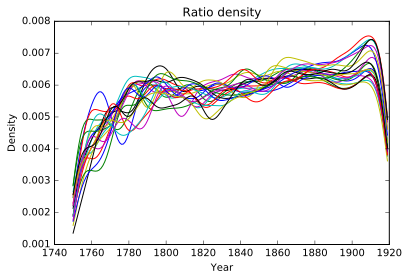

In [185]:
plot_pdfs([
    'translation',
    'philosophy',
    'philosopher',
    'history',
    'wrote',
    'ages',
    'philosophical',
    'descriptions',
    'heroic',
    'athens',
    'language',
    'ancient',
    'lecture',
    'moral',
    'essay',
    'narrative',
    'hebrew',
    'dialogue',
    'verses',
    'historians',
    'greeks',
])

### Drama, poetry

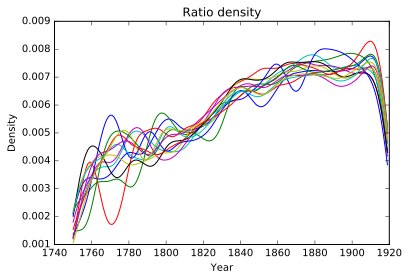

In [187]:
plot_pdfs([
    'epic',
    'insight',
    'audiences',
    'songs',
    'achievements',
    'plays',
    'actors',
    'problems',
    'shakespeare',
    'heroes',
    'prose',
    'poets',
    'poet',
])

### Taxonomy, pedogogy

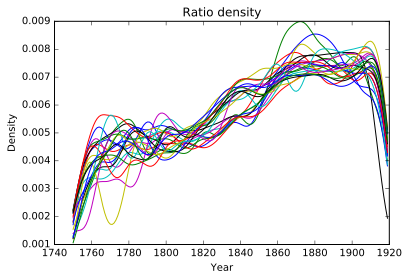

In [177]:
plot_pdfs([
    'geometry',
    'edit',
    'book',
    'inspiration',
    'rhetoric',
    'faculty',
    'english',
    'humour',
    'art',
    'famous',
    'epic',
    'insight',
    'audiences',
    'songs',
    'achievements',
    'plays',
    'actors',
    'problems',
    'shakespeare',
    'heroes',
    'prose',
    'poets',
    'poet',
])

### Religion

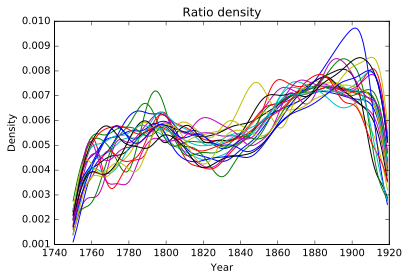

In [176]:
plot_pdfs([
    'chapters',
    'orthodox',
    'atheism',
    'christianity',
    'secular',
    'pub',
    'subjects',
    'treats',
    'discussions',
    'topics',
    'commentary',
    'exercises',
    'instructor',
    'index',
    'testament',
    'verse',
    'reader',
    'religious',
    'script',
    'metaphor',
    'bible',
    'teaching',
])